<a href="https://colab.research.google.com/github/arpandholakiya/ad916/blob/master/cam_flanch_calib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
pip install --upgrade tensorflow

In [45]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.layers import concatenate
import pandas as pd
import numpy as np
import argparse
import locale
import glob
import cv2
import os
import zipfile
from google.colab import files
from tensorflow.keras import preprocessing

In [46]:
print(tf.__version__)

2.5.0


In [47]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
#load data csv file
data = pd.read_csv("/content/gdrive/MyDrive/data/data_200/ef_poses.csv")

In [49]:
test_data = pd.read_csv("/content/gdrive/MyDrive/data/test_data/test.csv")

In [50]:
def append_ext(fn):
    return fn+".jpg"

data["image_name"]=data["image_name"].apply(append_ext)
test_data["image_name"]=test_data["image_name"].apply(append_ext)

In [51]:
data

,itteration,image_name,ef_position_x,ef_position_y,ef_position_z,ef_orientation_x,ef_orientation_y,ef_orientation_z,ef_orientation_w,labels_position_x,labels_position_y,labels_position_z,labels_orientation_x,labels_orientation_y,labels_orientation_z,labels_orientation_w,image_path
0,1,savedImage1.jpg,0.970629,0.255796,0.289298,-0.707213,-0.706999,0.000885,0.000936,0.09,0.000,-0.015,1.000000,0.000000,0.000000,1.034116e-13,/home/arpan/sim_images/savedImage1.jpg
1,2,savedImage2.jpg,0.908533,0.255847,0.289457,-0.707227,-0.706986,0.000975,0.000955,0.09,0.000,-0.015,1.000000,0.000000,0.000000,1.034116e-13,/home/arpan/sim_images/savedImage2.jpg
2,3,savedImage3.jpg,0.908533,0.255847,0.289457,-0.707227,-0.706986,0.000975,0.000955,0.09,0.000,-0.015,1.000000,0.000000,0.000000,1.034116e-13,/home/arpan/sim_images/savedImage3.jpg
3,4,savedImage4.jpg,0.792962,0.255889,0.289699,-0.707205,-0.707007,0.000900,0.000957,0.09,0.000,-0.015,1.000000,0.000000,0.000000,1.034116e-13,/home/arpan/sim_images/savedImage4.jpg
4,5,savedImage5.jpg,0.792936,0.255963,0.289640,0.702745,0.702566,0.079184,0.079247,0.09,0.000,-0.015,1.000000,0.000000,0.000000,1.034116e-13,/home/arpan/sim_images/savedImage5.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,196,savedImage196.jpg,0.369702,0.256064,0.580241,0.707131,0.706969,0.008950,0.008980,0.07,0.005,0.002,0.999775,-0.014998,-0.014998,-2.249831e-04,/home/arpan/sim_images/savedImage196.jpg
195,197,savedImage197.jpg,0.370582,0.256034,0.547473,-0.704647,-0.704446,0.060109,0.060134,0.07,0.005,0.002,0.999775,-0.014998,-0.014998,-2.249831e-04,/home/arpan/sim_images/savedImage197.jpg
196,198,savedImage198.jpg,0.405999,0.255996,0.494919,-0.704664,-0.704433,0.060059,0.060128,0.07,0.005,0.002,0.999775,-0.014998,-0.014998,-2.249831e-04,/home/arpan/sim_images/savedImage198.jpg
197,199,savedImage199.jpg,0.485401,0.255983,0.439103,-0.704663,-0.704444,0.060013,0.060058,0.07,0.005,0.002,0.999775,-0.014998,-0.014998,-2.249831e-04,/home/arpan/sim_images/savedImage199.jpg


In [52]:
test_data

,itteration,image_name,ef_position_x,ef_position_y,ef_position_z,ef_orientation_x,ef_orientation_y,ef_orientation_z,ef_orientation_w,labels_position_x,labels_position_y,labels_position_z,labels_orientation_x,labels_orientation_y,labels_orientation_z,labels_orientation_w,image_path
0,201,savedImage201.jpg,0.651492,0.256354,0.323843,0.704834,0.705038,0.055334,0.055388,0.075,0.0045,0.0015,0.999819,-0.017499,-0.007499,-0.000131,/home/arpan/sim_images/savedImage201.jpg
1,202,savedImage202.jpg,0.535769,0.256256,0.362044,0.706911,0.707061,0.013079,0.013084,0.075,0.0045,0.0015,0.999819,-0.017499,-0.007499,-0.000131,/home/arpan/sim_images/savedImage202.jpg
2,203,savedImage203.jpg,0.435945,0.256222,0.473654,-0.706414,-0.706538,0.029879,0.029855,0.075,0.0045,0.0015,0.999819,-0.017499,-0.007499,-0.000131,/home/arpan/sim_images/savedImage203.jpg
3,204,savedImage204.jpg,0.395084,0.256002,0.393387,-0.707228,-0.706984,0.000941,0.000953,0.085,0.0030,0.0010,0.999819,0.017499,-0.007499,0.000131,/home/arpan/sim_images/savedImage204.jpg
4,205,savedImage205.jpg,0.491785,0.255958,0.530171,-0.703659,-0.703401,0.071014,0.071048,0.085,0.0030,0.0010,0.999819,0.017499,-0.007499,0.000131,/home/arpan/sim_images/savedImage205.jpg
5,206,savedImage206.jpg,0.606411,0.255942,0.584508,0.707156,0.706951,0.008717,0.008681,0.085,0.0030,0.0010,0.999819,0.017499,-0.007499,0.000131,/home/arpan/sim_images/savedImage206.jpg
6,207,savedImage207.jpg,0.658767,0.256009,0.301871,-0.706085,-0.705960,0.039122,0.039176,0.080,0.0020,-0.0250,0.999809,0.014998,-0.012498,0.000187,/home/arpan/sim_images/savedImage207.jpg
7,208,savedImage208.jpg,0.664620,0.255903,0.353954,0.705709,0.705438,0.046508,0.046567,0.080,0.0020,-0.0250,0.999809,0.014998,-0.012498,0.000187,/home/arpan/sim_images/savedImage208.jpg
8,210,savedImage210.jpg,0.520264,0.255982,0.403780,-0.707225,-0.706989,0.000270,0.000218,0.080,0.0020,-0.0250,0.999809,0.014998,-0.012498,0.000187,/home/arpan/sim_images/savedImage210.jpg
9,211,savedImage211.jpg,0.454557,0.256012,0.441720,-0.705615,-0.705431,0.047276,0.047329,0.080,0.0020,-0.0250,0.999809,0.014998,-0.012498,0.000187,/home/arpan/sim_images/savedImage211.jpg


In [53]:
ef_poses = tf.constant(data[['ef_position_x','ef_position_y', 'ef_position_z', 'ef_orientation_x', 'ef_orientation_y',
                'ef_orientation_z', 'ef_orientation_w']].to_numpy())
labels = tf.constant(data[['labels_position_x', 'labels_position_y', 'labels_position_z', 
                'labels_orientation_x', 'labels_orientation_y', 'labels_orientation_z', 'labels_orientation_w']].to_numpy())

ef_poses, labels

(<tf.Tensor: shape=(199, 7), dtype=float64, numpy=
 array([[ 9.70629166e-01,  2.55796295e-01,  2.89298019e-01, ...,
         -7.06999382e-01,  8.84979760e-04,  9.36184002e-04],
        [ 9.08533237e-01,  2.55847000e-01,  2.89456502e-01, ...,
         -7.06985513e-01,  9.74659515e-04,  9.54885535e-04],
        [ 9.08533237e-01,  2.55847000e-01,  2.89456502e-01, ...,
         -7.06985513e-01,  9.74659515e-04,  9.54885535e-04],
        ...,
        [ 4.05998670e-01,  2.55995734e-01,  4.94919375e-01, ...,
         -7.04433157e-01,  6.00589457e-02,  6.01283977e-02],
        [ 4.85401453e-01,  2.55982732e-01,  4.39103060e-01, ...,
         -7.04443723e-01,  6.00134271e-02,  6.00583442e-02],
        [ 5.04396369e-01,  2.56029194e-01,  5.49774207e-01, ...,
         -6.95460263e-01,  1.27358831e-01,  1.27368367e-01]])>,
 <tf.Tensor: shape=(199, 7), dtype=float64, numpy=
 array([[ 9.00000000e-02,  0.00000000e+00, -1.50000000e-02, ...,
          0.00000000e+00,  0.00000000e+00,  1.03411554e-13],


In [41]:
# test_ef_poses = tf.constant(test_data[['ef_position_x','ef_position_y', 'ef_position_z', 'ef_orientation_x', 'ef_orientation_y',
#                 'ef_orientation_z', 'ef_orientation_w']].to_numpy())

# test_labels = tf.constant(test_data[['labels_position_x', 'labels_position_y', 'labels_position_z', 
#                 'labels_orientation_x', 'labels_orientation_y', 'labels_orientation_z', 'labels_orientation_w']].to_numpy())


# test_ef_poses[4], test_labels[4]

(<tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([ 0.49178499,  0.25595848,  0.53017116, -0.70365874, -0.70340143,
         0.07101442,  0.07104757])>,
 <tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([ 8.50000000e-02,  3.00000000e-03,  1.00000000e-03,  9.99818758e-01,
         1.74986146e-02, -7.49878129e-03,  1.31242071e-04])>)

In [54]:
print(tf.__version__)
print(tf.keras.__version__)

2.5.0
2.5.0


In [55]:
train_ef_poses = ef_poses[:160]
val_ef_poses = ef_poses[160:]
train_ef_poses, val_ef_poses

(<tf.Tensor: shape=(160, 7), dtype=float64, numpy=
 array([[ 9.70629166e-01,  2.55796295e-01,  2.89298019e-01, ...,
         -7.06999382e-01,  8.84979760e-04,  9.36184002e-04],
        [ 9.08533237e-01,  2.55847000e-01,  2.89456502e-01, ...,
         -7.06985513e-01,  9.74659515e-04,  9.54885535e-04],
        [ 9.08533237e-01,  2.55847000e-01,  2.89456502e-01, ...,
         -7.06985513e-01,  9.74659515e-04,  9.54885535e-04],
        ...,
        [ 3.11549611e-01,  2.56258271e-01,  4.84699323e-01, ...,
          7.06708208e-01,  2.74893510e-02,  2.74780204e-02],
        [ 3.82604512e-01,  2.56256292e-01,  4.90202439e-01, ...,
         -7.06730015e-01,  2.56792844e-02,  2.56670765e-02],
        [ 3.84813667e-01,  2.56249464e-01,  5.20346854e-01, ...,
         -7.06712998e-01,  2.57179239e-02,  2.57039582e-02]])>,
 <tf.Tensor: shape=(39, 7), dtype=float64, numpy=
 array([[ 0.51717939,  0.25625922,  0.51067527,  0.70313818,  0.70327188,
          0.074184  ,  0.07417617],
        [ 0.64658

In [56]:
train_labels = labels[:160]
val_labels = labels[160:]
train_labels, val_labels

(<tf.Tensor: shape=(160, 7), dtype=float64, numpy=
 array([[ 9.00000000e-02,  0.00000000e+00, -1.50000000e-02, ...,
          0.00000000e+00,  0.00000000e+00,  1.03411554e-13],
        [ 9.00000000e-02,  0.00000000e+00, -1.50000000e-02, ...,
          0.00000000e+00,  0.00000000e+00,  1.03411554e-13],
        [ 9.00000000e-02,  0.00000000e+00, -1.50000000e-02, ...,
          0.00000000e+00,  0.00000000e+00,  1.03411554e-13],
        ...,
        [ 7.50000000e-02,  3.50000000e-02, -3.00000000e-02, ...,
          1.49982657e-02, -1.24982683e-02,  1.87488086e-04],
        [ 7.50000000e-02,  3.50000000e-02, -3.00000000e-02, ...,
          1.49982657e-02, -1.24982683e-02,  1.87488086e-04],
        [ 7.50000000e-02,  3.50000000e-02, -3.00000000e-02, ...,
          1.49982657e-02, -1.24982683e-02,  1.87488086e-04]])>,
 <tf.Tensor: shape=(39, 7), dtype=float64, numpy=
 array([[ 7.50000000e-02,  3.50000000e-02, -3.00000000e-02,
          9.99809387e-01,  1.49982657e-02, -1.24982683e-02,
       

In [57]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image
 # print(f"image name: {img.name}")

  return img

Image shape: (480, 640, 3)


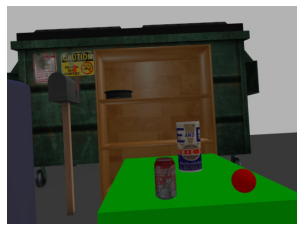

In [60]:
img = view_random_image('/content/gdrive/MyDrive/data/data_200/sim_images')

## To check
* ef_x = 
* ef_q = 
* label_x = 
* label_q =

In [23]:
#pip uninstall keras-preprocessing

In [24]:
#pip install git+https://github.com/keras-team/keras-preprocessing.git


In [61]:
pip install keras --upgrade

In [62]:
img_train_datagen_augmented = ImageDataGenerator(validation_split=0.2,
                                                 #rescale = 1/255.,
                                   #shear_range=0,
                                  
                                   #width_shift_range = 0.5,
                                   #height_shift_range = 0.5,
                                   horizontal_flip = True,
                                   rotation_range = 30)

In [63]:
train_generator = img_train_datagen_augmented.flow_from_dataframe(data,
                                                         directory = '/content/gdrive/MyDrive/data/data_200/sim_images',
                                                         x_col = 'image_name',
                                                         y_col = ['ef_position_x','ef_position_y', 'ef_position_z', 'ef_orientation_x', 'ef_orientation_y',
                'ef_orientation_z', 'ef_orientation_w','labels_position_x', 'labels_position_y', 'labels_position_z', 'labels_orientation_x', 'labels_orientation_y', 'labels_orientation_z', 'labels_orientation_w'],
                                                         target_size = (224,224),
                                                         batch_size = 1,
                                                         class_mode = 'raw',
                                                         seed = 42,
                                                         subset='training',
                                                         shuffle = False)

validation_generator = img_train_datagen_augmented.flow_from_dataframe(data,
                                                         directory = '/content/gdrive/MyDrive/data/data_200/sim_images',
                                                         x_col = 'image_name',
                                                        y_col = ['ef_position_x','ef_position_y', 'ef_position_z', 'ef_orientation_x', 'ef_orientation_y',
                'ef_orientation_z', 'ef_orientation_w','labels_position_x', 'labels_position_y', 'labels_position_z', 'labels_orientation_x', 'labels_orientation_y', 'labels_orientation_z', 'labels_orientation_w'],
                                                         target_size = (224,224),
                                                         batch_size = 1,
                                                         class_mode = 'raw',
                                                         seed = 42,
                                                         subset='validation',
                                                         shuffle = False)

Found 160 validated image filenames.
Found 39 validated image filenames.


[ 7.14048795e-01  2.55996459e-01  2.71334852e-01 -6.95950910e-01
 -6.95794389e-01  1.25544664e-01  1.25542969e-01  7.00000000e-02
  0.00000000e+00 -2.00000000e-02  1.00000000e+00  0.00000000e+00
  0.00000000e+00  1.03411554e-13]
uint8
image shape:(224, 224, 3)
255


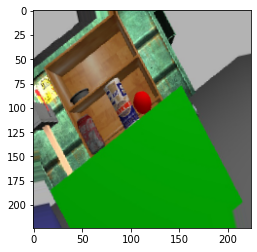

In [84]:
x_gen, y_gen = next(train_generator)

for i in range (1):
  image = x_gen[i].astype('uint8')
  pose = y_gen[i]
  print(pose)
  print(image.dtype)
  print(f'image shape:{image.shape}')
  print(np.max(image))
  plt.imshow(image)
  plt.show()

(224, 224, 3)
0.9921568627450981
(224, 224, 3)
0.9803921568627451


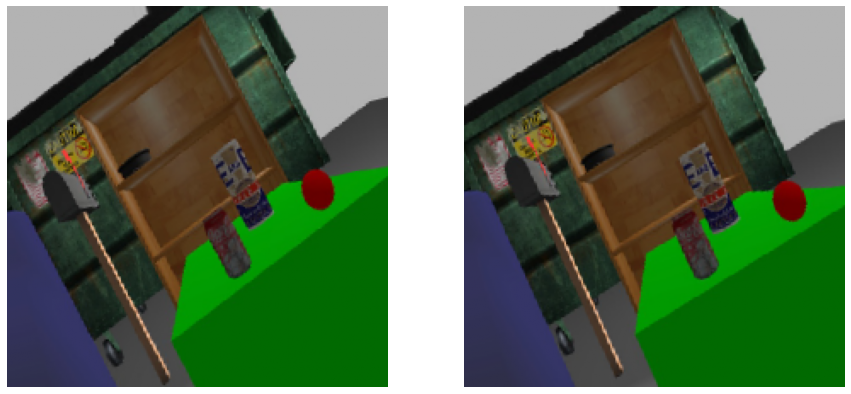

In [106]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# plotting images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))


for i in range(2):
    
# convert to unsigned integers for plotting
    image = next(train_generator)[0].astype('uint8')
    image = image/255.
# changing size from (1, 224, 224, 3) to (224, 224, 3) for plotting the image
    image = np.squeeze(image)
    
    print(image.shape)
    print(np.max(image))

# plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

# Issues
- Normalising images

# further training

* loss functions



In [89]:
imagenet_url = "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"

In [90]:
pip install git+https://github.com/ssuwani/pytube 

  Cloning https://github.com/ssuwani/pytube to /tmp/pip-req-build-hebbe0mx
  Running command git clone -q https://github.com/ssuwani/pytube /tmp/pip-req-build-hebbe0mx


In [91]:
pip install keras-utils

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 1024)         5607184     input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 20)           160         input_4[0][0]                    
____________________________________________________________________________________________

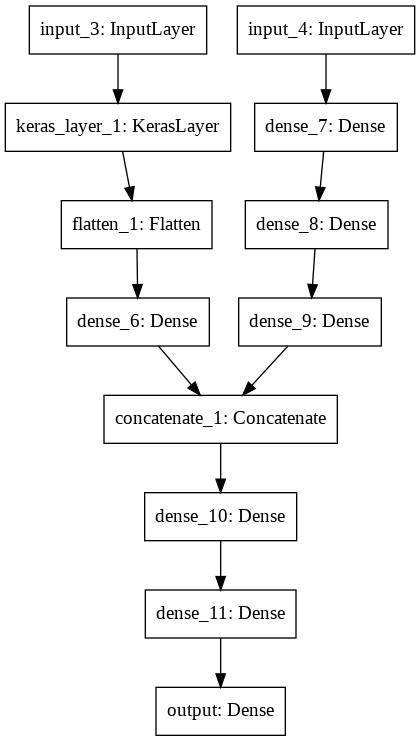

In [92]:
# Multiple Inputs
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate

# first branch : input = Image
visible1 = Input(shape=(224,224,3))
x = hub.KerasLayer(imagenet_url, trainable=False)(visible1) #pretrained imagenet model
flat1 = Flatten()(x)
x1 = Dense(7, activation='relu')(flat1)

# second branch : input = ef_pose
visible2 = Input(shape=(7,))
x2 = Dense(20, activation='relu')(visible2)
x3 = Dense(20, activation='relu')(x2)
x4 = Dense(7, activation='relu')(x3)

# merge input branches
merge = concatenate([x1, x4])

# interpretation model
hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(7, activation='linear', name='output')(hidden2)
model_1 = Model(inputs=[visible1, visible2], outputs=output)

# summarize layers
print(model_1.summary())

# plot graph
plot_model(model_1, to_file='multiple_inputs.png')

In [115]:
batch_size = 4

def gen_flow_for_two_inputs(X1, X2, y, gen):
    genX1 = gen.flow(X1, y,  batch_size=batch_size,seed=123)
    #genX2 = gen.flow(X2, y, batch_size=batch_size, seed=123)
    while True:
      X1i = genX1.next() #image and labels
      #X2i = genX2.next()
      #Assert arrays are equal - this was for peace of mind, but slows down training
      #np.testing.assert_array_equal(X1i[0],X2i[0])
      #print('hi')
      #yield [X1i[0], X2i[0]], X1i[1][:,7:]
      yield [X1i[0], X1i[1][:,0:7]], X1i[1][:,7:]

# Finally create generator
def gen_flow(gen, generator, ef_p):
    x_gen ,y_gen = next(generator)
    np.squeeze(x_gen)
    print(x_gen.shape,y_gen[:,0:7].shape)
    print(ef_p.shape)
    gen_flow = gen_flow_for_two_inputs(x_gen, ef_p, y_gen, gen)
    #print(x_gen.shape,y_gen[:,0:7].shape)
    #print(ef_p.shape)
    return gen_flow

gen_flow_train = gen_flow(img_train_datagen_augmented, train_generator, train_ef_poses)
gen_flow_val = gen_flow(img_train_datagen_augmented, validation_generator, val_ef_poses)


#def generator_two_img(X1, X2, Y):
    

 #   genX1 = img_train_datagen_augmented.flow(X1, Y)
  #  genX2 = img_train_datagen_augmented.flow(X2, Y)

   # while True:
    #    X1i = genX1.next()
     #   X2i = genX2.next()
      #  yield [X1i[0], X2i[0]], x1i[1]

(1, 224, 224, 3) (1, 7)
(160, 7)
(1, 224, 224, 3) (1, 7)
(39, 7)


In [102]:
len(gen_flow_train)

TypeError: ignored

In [101]:
model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])

history_1 = model_1.fit_generator(gen_flow_train,
            epochs = 5,
            steps_per_epoch = 40,
            validation_data = gen_flow_val,
            validation_steps = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
40/40 [==============================] - 2s 30ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 1.0000
Epoch 2/5
40/40 [==============================] - 1s 19ms/step - loss: 7.3881e-04 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 3/5
40/40 [==============================] - 1s 19ms/step - loss: 5.7876e-04 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 1.0000
Epoch 4/5
40/40 [==============================] - 1s 20ms/step - loss: 6.8500e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 1.0000
Epoch 5/5
40/40 [==============================] - 1s 20ms/step - loss: 6.3578e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 1.0000


In [99]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


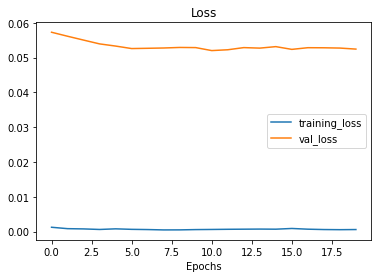

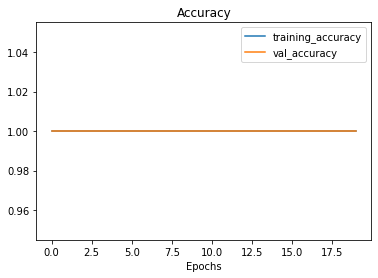

In [100]:
plot_loss_curves(history_1)

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  '''
  Reads in an image from filename, turns it into a tensor and 
  reshapes into (224, 224, 3).
  '''
  # Read in the image
  img = tf.io.read_file(filename)
  #decode it into a tensor
  img = tf.image.decode_jpeg(img)
  #resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  #resclae the image 
  img = img/255.
  return img

In [ ]:
test_image = load_and_prep_image('savedImage205.jpg')
test_image.shape, test_ef_poses[4].shape

In [ ]:
def pred_plot_evaluate(model, filename, test_ef_pose, test_label):
  '''
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the 
  title.
  '''
  # Import the target image and preprocess it.
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict([tf.expand_dims(img, axis=0), tf.expand_dims(test_ef_pose, axis=0)])
  results = model.evaluate([tf.expand_dims(img, axis=0), tf.expand_dims(test_ef_pose, axis=0)], tf.expand_dims(test_label, axis=0))

  # Get the predicted class
  #pred_class = class_names[int(tf.round(pred)[0][0])]
  print(results)
  # plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred}")
  plt.axis(False);

In [ ]:
pred_plot_evaluate(model_1, 'savedImage205.jpg', test_ef_poses[4], test_labels[4])

In [ ]:
# Regression model function for numerical data - multi layer perceptron

def create_mlp(dim, regress=False):
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))

	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))

	# return our model
	return model

In [ ]:
# CNN model function for image data

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)

	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

In [ ]:
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted regressed pose)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# python scripts for preprocess data
* normalise images and pose data
* image data augmentation ( random crop, flip-rotation, gray_scale values)
*  training experiments on colab after preprocessing data.

# further training
* data types
* loss functions
* input-shapes

* preprocess the labels also (normalise and one-hot)
* what other parameters are responsible for accurate camera pose estimation other than camera images and ef_poses.
